## Блокнот для прикидки влияния отдельных параметров


In [1]:
# from utils import X,y,cat_cols,fillna,normalize,skew,encode
from task import *
import gc
gc.collect()

1131

### Для тестирования используется тренировочный набор
Набор разделён на обучающий и тестовый  в соотношении 3:1 без перемешивания 

In [2]:
def data():
    split = 300_000
    maxlines = 500_000
    d2 = pd.read_csv('datasets/train.csv',skiprows= range(1,split) )
    d1 = pd.read_csv('datasets/train.csv',skiprows= range(split,maxlines) )
    return(d1,d2)  


### Класс для прогона тестов
На экран выводится метрика MAPE на тетсовом наборе 
Кроме того, базовый класс записывает метрику в лог, откуда её можно извлечь

In [3]:
class Loader(Task):

    def __init__( self, data, params = {}):
        super().__init__(data, params)
        self.ds = ScoreSet( data[0],data[1] ,params=self.params)

    def process(self,ds = None ):
        if ds==None:
            ds = self.ds
        ds.set_encoder( self.new_encoder() ).set_model(self.new_model() )
        ds.prepare().fit().predict()
        self.log +=(f"{ds.log}\t MAPE:{ds.scores()}\n")          

    

### Загрузка модели

In [4]:
params = { 
        'rounding': {'odometer': 1000, 'condition': 1, 'prefix_size': 10}, 
        'model': {'criterion': 'poisson', 'n_estimators': 64, 'max_depth': 32, 'min_samples_leaf': 2, 'max_features': 16},
        'slice': {
            'cat_cols': ['make', 'model', 'trim', 'body', 'transmission', 'state', 'seller', 'year', 'odometer', 'condition']
                }, 
        'model_class': RandomForestRegressor,
        'encoder_class': TargetEncoder,
        'encoder': {'min_samples_leaf': 2, 'smoothing': 5},
        'sellers': {'stages': 6} 
        }

v = Loader( data() ,params=params)
v.process()
print(v.log)       
        
            

	 MAPE:0.1336496361697295



In [9]:
import matplotlib.pyplot as  plt

# fis = v.ds.model.feature_importances_.argsort()
# plt.barh(v.ds.model.feature_names_in_, v.ds.model.feature_importances_[fis]);
# plt.xlabel("Влияние признаков на цену автомобиля");

### Неравномерность оценки по категориям цен 

In [10]:
diff = pd.DataFrame({'predict':v.ds.pr,'price':v.ds.te.sellingprice} )

In [11]:
split_price_idx = [1000,3000,5000,10_000,15_000,20_000]
split_price_MAPE = pd.DataFrame(index=split_price_idx, columns=['above','below'] )

for split_price in split_price_idx:
    split_price_MAPE.loc[split_price,'above']=mape(diff[diff.price>split_price].predict,diff[diff.price>split_price].price)
    split_price_MAPE.loc[split_price,'below']=mape(diff[diff.price<split_price].predict,diff[diff.price<split_price].price)

Text(0, 0.5, 'MAPE score')

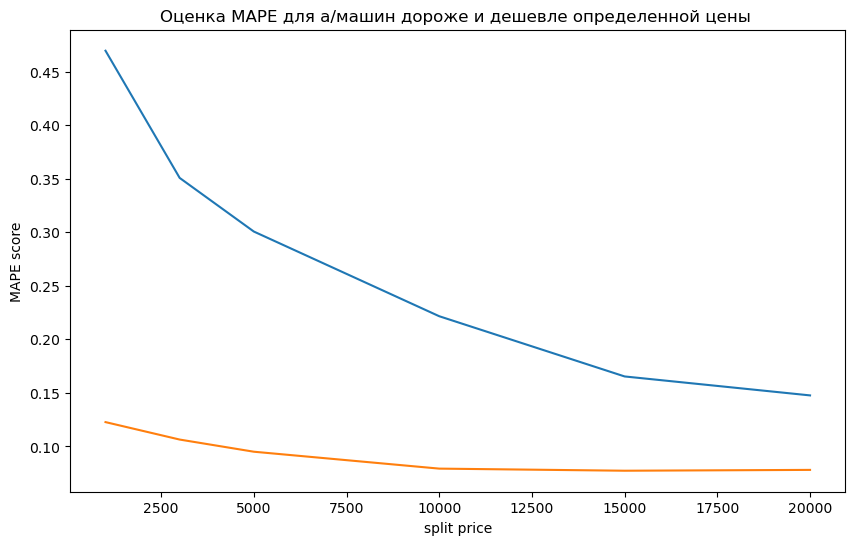

In [12]:
plt.figure(figsize=(10, 6))
plt.title('Оценка MAPE для а/машин дороже и дешевле определенной цены ')
plt.plot( split_price_MAPE.index,split_price_MAPE.below);
plt.plot( split_price_MAPE.index,split_price_MAPE.above);
plt.xlabel('split price')
plt.ylabel('MAPE score')